#### <a id='top'></a>

# Homework 2: Data Visualization and Probability Analysis 
***

**Name**: Nikolai Lyssogor

***

This assignment is due on Canvas by **MIDNIGHT on Monday September 14**. Your solutions to theoretical questions should be done in Markdown directly below the associated question.  Your solutions to computational questions should include any specified Python code and results as well as written commentary on your conclusions.  Remember that you are encouraged to discuss the problems with your classmates, but **you must write all code and solutions on your own**.

**NOTES**: 

- Any relevant data sets should be available under the **Data** module on Canvas. To make life easier on the graders if they need to run your code, do not change the relative path names here. Instead, move the files around on your computer.
- If you're not familiar with typesetting math directly into Markdown then by all means, do your work on paper first and then typeset it later.  Remember that there is a [reference guide](https://math.meta.stackexchange.com/questions/5020/mathjax-basic-tutorial-and-quick-reference) linked on Canvas on writing math in Markdown. **All** of your written commentary, justifications and mathematical work should be in Markdown.
- Because you can technically evaluate notebook cells is a non-linear order, it's a good idea to do Kernel $\rightarrow$ Restart & Run All as a check before submitting your solutions.  That way if we need to run your code you will know that it will work as expected. 
- It is **bad form** to make your reader interpret numerical output from your code.  If a question asks you to compute some value from the data you should show your code output **AND** write a summary of the results in Markdown directly below your code. 
- 95 points of this assignment are in problems.  The remaining 5 are for neatness, style, and overall exposition of both code and text.
- This probably goes without saying, but... For any question that asks you to calculate something, you **must show all work and justify your answers to receive credit**. Sparse or nonexistent work will receive sparse or nonexistent credit. 

---
**Shortcuts:**  [Problem 1](#p1) | [Problem 2](#p2) | [Problem 3](#p3) |

---

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

def my_sample_mean(np_arr):
    total = 0
    for i in range(0, np_arr.size):
        total = total + np_arr[i]
    return total / np_arr.size

def my_sample_var(np_arr):
    mean = my_sample_mean(np_arr)
    total = 0
    for i in range(0, np_arr.size):
        total = total + (np_arr[i] - mean) * (np_arr[i] - mean)
    return total / (np_arr.size - 1)

bus = np.array([312, 4, 10, 0, 22, 39, 81, 19, 8, 60, 80, 42])
print("sample mean: %f" % my_sample_mean(bus))
print("sample variance: %f\n" % my_sample_var(bus))

def update_mean(prev_mean, xn, n):
    now_mean = prev_mean + (xn - prev_mean) / n
    return now_mean

#first value added manually
buffbus_bad_means = np.array([312, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

for i in range(1, 12):
    buffbus_bad_means[i] = update_mean(buffbus_bad_means[i - 1], bus[i], 12)

print("buffbus_bad_means: ")
print(buffbus_bad_means)

assert update_mean(1,2,3)==4/3, "Warning: function seems broken."

# problem 3:
filepath = 'titanic_data.csv'
df = pd.read_csv(filepath)
df.head()

prob_survived = (df["Survived"].sum() / len(df["Survived"])) * 100
print("{} % of people survived".format(prob_survived))

dfTitanic = df.dropna(subset = ["Age"], inplace = True)

sample mean: 56.416667
sample variance: 7274.628788

buffbus_bad_means: 
[312 286 263 241 222 206 195 180 165 156 149 140]
39.28170594837261 % of people survived


NameError: name 'true' is not defined

[Back to top](#top)

<br>

<a id='p1'></a>

## (15 points) Problem 1: Theory (Median Distance)
***

One way we conceptualize many data science questions is asking for the "best choice" of some parameter on data set.  We should be able to justify that our measures of centrality should in some way be the "best" ways to represent the data.


In lecture, we may have discussed the following important property of the mean:


The *sample mean* of data $X_1, X_2, \dots X_n$ is the unique minimizer $c$ of the function $$f(c)=\sum_{i=1}^n \left(X_i-c \right)^2. $$

The proof of that claim is as follows:

**Proof:**

Differentiating yields
$$f'(c)=\frac{df}{dc}\sum_{i=1}^n \left(X_i-c \right)^2 =\sum_{i=1}^n-2(X_i-c).$$ 

Setting $f'(c)=0$ gives

$$0=\sum_{i=1}^n-2(X_i-c)$$
$$=2nc-2\sum_{i=1}^n X_i$$
$$\implies\qquad  c=\frac{\sum_{i=1}^n X_i}{n}=\bar{X}$$

***

### Your exercise:

You are tasked with recreating a *similar* proof.  Prove the following:

The *median* of data $X_1, X_2, \dots X_n$ is the possibly non-unique minimizer $c$ of the function $$f(c)=\sum_{i=1}^n |X_i-c| $$

A few things to think about:

 - how do we differentiate the absolute value function?
 - what conditions might make the median non-unique in this case?  If it's nonunique, what possible values of $c$ still minimize the function $f$?

$$\frac{df}{dc}\sum_{i=1}^n |x_i-c| = \sum_{i=1}^n \frac{x_i-c}{|x_i-c|}$$
$$=\sum_{i=1}^n -1 = -n$$ or $$\sum_{i=1}^n 1 = n$$

The uniqueness or lack thereof of the minimizer $c$ in this problem depends on whether the cardinality of $X$ is odd or even. This makes sense given how we find the median intuitively: If there are an odd number of values, the median is the single, exact middle value of the sorted list. But if there are an even number of values, we take the average of the two middle values. This equation, however, is not powerful enough to actually average the values.

[Back to top](#top)
<a id='p2'></a>

## (40 pts) Problem 2: Computation (Streaming Means)
***

Data science is often divided into two categories: questions of *what* the best value might be to repreesnt a data problem, and questions of *how* to compute that data value.  Question 1 - and prior lectures - should tell you that computing the mean is valuable!  But *how* do we compute the mean?

Let $x_1, x_2, \ldots, x_n$ be $n$ observations of a variable of interest.  Recall that the sample mean $\bar{x}_n$ and sample variance $s^2_n$ are given by 
<a id='eq1'></a>
$$
\bar{x}_n = \frac{1}{n}\sum_{k=1}^n x_k \quad \textrm{and} \quad s^2_n = \frac{1}{n-1}\sum_{k=1}^n \left( x_k - \bar{x}_n\right)^2 \qquad \tag{Equation 1}
$$

**Part A**:

How many computations - floating point operations: addition, subtraction, multiplication, division each count as 1 operation - are required to compute the mean of the data set with $n$ observations?


$n$ division operations are required to compute $x_k/n$ n times, and $n - 1$ addition operations are required to sum the aforementioned division. So the total operations required is $2n - 1$.

**Part B**:

Now suppose our data is *streaming*- we slowly add observations one at a time, instead of seeing the entire data set at once.  We are still interested in the mean, so if we stream the data set `[4,6,0,10, ...]`, we first compute the mean of the the first data point `[4]`, then we recompute the mean of the first two points `[4,6]`, then we recompute the mean of three `[4,6,0]`, and so forth.

Suppose we recompute the mean from scratch after each and every one of our $n$ observations are one-by-one added to our data set.  How many floating point operations are spent computing (and re-computing) the mean of the data set?

In this case we would need to compute the mean $n$ times, so the number of operations is $n(2n - 1) = 2n^2 - n$.

We should be convinced that streaming a mean costs a lot more computer time than just computing once!

In this problem we explore a smarter method for such an _online_ computation of the mean.  

**Result**: The following relation holds between the mean of the first $n-1$ observations and the mean of all $n$ observations: 

$$
\bar{x}_n = \bar{x}_{n-1} + \frac{x_n - \bar{x}_{n-1}}{n}
$$


A proof of this result is in the [Appendix](#Appendix) after problem 3, and requires some careful manipulations of the sum $\bar{x}_n$.  Your task will be to computationally verify and utilize this result.

**Part C**: Write a function `my_sample_mean` that takes as its input a numpy array and returns the mean of that numpy array using the formulas from class ([Equation 1](#eq1)). Write another function `my_sample_var` that takes as its input a numpy array and returns the variance of that numpy array, again using the formulas from class ([Equation 1](#eq1)). You may **not** use any built-in sample mean or variance functions.

In [10]:
def my_sample_mean(np_arr):
    total = 0
    for i in range(0, np_arr.size):
        total = total + np_arr[i]
    return total / np_arr.size

def my_sample_var(np_arr):
    mean = my_sample_mean(np_arr)
    total = 0
    for i in range(0, np_arr.size):
        total = total + (np_arr[i] - mean) * (np_arr[i] - mean)
    return total / (np_arr.size - 1)

**Part D**: Use your functions from Part B to compute the sample mean and sample variance of the following array, which contains the minutes late that the BuffBus is running on Friday afternoon.

`bus = [312, 4, 10, 0, 22, 39, 81, 19, 8, 60, 80, 42]`

In [11]:
bus = np.array([312, 4, 10, 0, 22, 39, 81, 19, 8, 60, 80, 42])
print("sample mean: %f\n" % my_sample_mean(bus))
print("sample variance: %f" % my_sample_var(bus))

sample mean: 56

sample variance: 7274


**Part E**: Implement a third function called `update_mean` that implements the formula discussed after part B. Note that this function will need to take as its input three things: $x_n$, $\bar{x}_{n-1}$ and $n$, and returns $\bar{x}_{n}$. A function header and return statement are provided for you. This function may be auto-graded, so please do not change the given header API - the order of inputs matters! If you change it, you might lose points.

Use this function to compute the values that you get from taking the mean of the first buff buses' lateness, the first two buff buses' lateness, the first three buff buses' lateness, and so on up to all of the `bus` data points from **Part D**. Store your streaming bus means in a numpy array called `buffbus_bad_means`.  Report all 12 estimates in `buffbus_bad_means`.

In [28]:
# Given API:
def update_mean(prev_mean, xn, n):
    now_mean = prev_mean + (xn - prev_mean) / n
    return now_mean

#first value added manually
buffbus_bad_means = np.array([312.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

for n in range(1, 12):
    buffbus_bad_means[n] = update_mean(buffbus_bad_means[n - 1], bus[n], n + 1)

print("buffbus_bad_means: ")
print(buffbus_bad_means)

buffbus_bad_means: 
[312.         158.         108.66666667  81.5         69.6
  64.5         66.85714286  60.875       55.          55.5
  57.72727273  56.41666667]


**You may report any results for part E here, if not done using print() statements**

To ensure your function complies with the given API, run this small test, where we suppose we have a mean of $\bar{x}_n = 1$ with the first $2$ data points (`prev_mean`), and we update this with the 3rd ($n=3$) data point which is $x_3=2$:

In [29]:
assert update_mean(1,2,3)==4/3, "Warning: function seems broken."

**Part F**:

How many floating point operations were spent computing the final result in your code in **part E**?  Is this truly better than the uninformed approach from **part B**?

The bottom-up approach in part E required $3n$ operations. This is much more efficient than the approach in part B because we are storing the mean of the $k - 1$ element to compute element $k$ rather than summing all $k - 1$ elements and dividing every time we compute element $k$.

[Back to top](#top)

<a id='p3'></a>

## (40 pts) Problem 3: Data (Probability and Histograms)
*** 
The sinking of the RMS Titanic was a terrible tragedy that saw the loss of many lives. Even within this tragedy, thanks to the combinations of the records of the White Star Line and the thorough nature of follow-up research after the accident we have some records that can help us try to piece together the course of events on board the ship. Many of the historians and other researchers who have investigated this event have speculated as to what exactly happened.

We have the data on survival rates by class, gender, and age, so let's figure out whether there is evidence for some of these scenarios. Access the Titanic data in `titanic_data.csv` and store it in a Pandas DataFrame. The data contains information pertaining to class status (**Pclass**), survival (**Survived**), and gender (**Sex**) of passengers, among other things. Be sure to use the `titanic_data.csv` data set, *not* the `clean_titanic_data` file or `dirty_titanic_data` file from the in-class notebook exercises.

In [30]:
filepath = 'titanic_data.csv'
df = pd.read_csv(filepath)
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,36.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,18.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,14.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,27.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,63.0,0,0,373450,8.0500,NaN,S


**Part A**:
Based on the overall population of passengers, report the probability of survival.

$$P(Survived=1)$$

In [38]:
prob_survived = (df["Survived"].sum() / len(df["Survived"])) * 100
print("{} % of people survived".format(prob_survived))

39.28170594837261 % of people survived


**Part B**: 
Some claim that the final hours aboard the RMS Titanic were marked by "class warfare" in which the people with first-class tickets took all the good spots on the lifeboats; others claim that the final hours were characterized by male chivalry, in which the men valiantly gave up their positions in the boats and succumbed bravely to the depths of the Atlantic. 

Consider the two claims: class warfare, and male chivalry. Suppose that class warfare occurred in the final hours aboard the Titanic.  What patterns might you expect to see in the data?  Suppose that male chivalry was widespread during the final hours instead. What patterns might you then expect to see in the data?  Explain both of these hypothesized patterns in words. Are these two hypotheses mutually exclusive or not?

For the former hypothesis, you would expect to see the percentage of people who survived be higher for those in first-class as compared to the lower two classes. Similarly, the data may show that men over a certain age in any class survived at a higher rate than women or men below that age. These hypotheses are no mutually exclusive, however. It could be the case that if you considered both parameters simultaneously, you would find that men in thrid-class had the lowest chance of survival, whereas women and children in first-class survived at the highest rate. 

**Part C**: Use Pandas methods to create a clean data set by removing any rows from the DataFrame that are missing values corresponding to **Survived**, **Pclass**, **Age**, or **Sex**. Store the clean data in a DataFrame called dfTitanic. Be sure to show any exploratory work determining if/where there are rows with missing values. _HINT: There should be 714 rows in your cleaned data set._

In [48]:
#I noticed in the .csv file that the only on of the aforementioned columns with empty values was 'Age'
dfTitanic = df[pd.notnull(df['Age'])]

714


**Part D**: Compute the probability of survival according to class, gender, and all combinations of the two variables.  Then, answer the following questions:
* **(i)** When reviewing class survival probability, how do the results compare to the base survival probability results from **Part A**?
* **(ii)** When reviewing gender survival probability, how do the results compare to the base survival probability results from **Part A**?
* **(iii)** Within each passenger class, were men or women more/less/equally likely to survive?
* **(iv)**  Did men in first class or women in third class have a higher survival probability?


In [116]:
num_passengers = 714

#first class
first_class = dfTitanic.loc[dfTitanic["Pclass"] == 1]
first_class_num = len(first_class)
first_class_survived = (first_class["Survived"].sum() / first_class_num) * 100
print("{} percent of first class passengers survived".format(first_class_survived))

#lower classes
low_class = dfTitanic.loc[dfTitanic["Pclass"] != 1]
low_class_num = len(low_class)
low_class_survived = (low_class["Survived"].sum() / low_class_num) * 100
print("{} percent of lower class passengers survived".format(low_class_survived))

#men
male = dfTitanic.loc[dfTitanic["Sex"] == 'male']
male_num = len(male)
male_survived = (male["Survived"].sum() / male_num) * 100
print("{} percent of male passengers survived".format(male_survived))

#female
female = dfTitanic.loc[dfTitanic["Sex"] == 'female']
female_num = len(female)
female_survived = (female["Survived"].sum() / female_num) * 100
print("{} percent of female passengers survived".format(female_survived))

#female first class
female_firstClass = dfTitanic.loc[(dfTitanic["Sex"] == 'female') & (dfTitanic["Pclass"] == 1)]
female_firstClass_num = len(female_firstClass)
female_firstClass_survived = (female_firstClass["Survived"].sum() / female_firstClass_num) * 100
print("{} percent of female, first-class passengers survived".format(female_firstClass_survived))

#male first class
male_firstClass = dfTitanic.loc[(dfTitanic["Sex"] == 'male') & (dfTitanic["Pclass"] == 1)]
male_firstClass_num = len(male_firstClass)
male_firstClass_survived = (male_firstClass["Survived"].sum() / male_firstClass_num) * 100
print("{} percent of male, first-class passengers survived".format(male_firstClass_survived))

#female lower class
female_lowerClass = dfTitanic.loc[(dfTitanic["Sex"] == 'female') & (dfTitanic["Pclass"] != 1)]
female_lowerClass_num = len(female_lowerClass)
female_lowerClass_survived = (female_lowerClass["Survived"].sum() / female_lowerClass_num) * 100
print("{} percent of female, lower-class passengers survived".format(female_lowerClass_survived))

#male lower class
male_lowerClass = dfTitanic.loc[(dfTitanic["Sex"] == 'male') & (dfTitanic["Pclass"] != 1)]
male_lowerClass_num = len(male_lowerClass)
male_lowerClass_survived = (male_lowerClass["Survived"].sum() / male_lowerClass_num) * 100
print("{} percent of male, lower-class passengers survived".format(male_lowerClass_survived))

64.28571428571429 percent of first class passengers survived
31.318681318681318 percent of lower class passengers survived
19.654427645788335 percent of male passengers survived
74.9003984063745 percent of female passengers survived
96.0 percent of female, first-class passengers survived
38.70967741935484 percent of male, first-class passengers survived
65.9090909090909 percent of female, lower-class passengers survived
14.864864864864865 percent of male, lower-class passengers survived
39.075630252100844 % of people survived


**(i)** A passenger was about 26% more likely to survive if they were first-class, based on class alone. They were about 8% less likely to survive if they were in a lower class based on class alone.

**(ii)** A passenger was 20% less likely to survive if he was male and 40% likely if she were female to survive based on sex alone.

**(iii)** Within first-class, women were 60% more likely to survive. Within the lower classes, women were 50% more likely to survive.

**(iv)** Male, first-class passengers were still 27% less likely to survive based on sex and class.

**Part E**: One might wonder how a passenger's age is related to the likelihood that they would survive the Titanic disaster. In addition to the "male chivalry" argument outlined above, you can perhaps imagine an addendum - "women and children first!" - as the cry to ring out across the decks. Or you might imagine the opposite - rather than "class warfare", it is simply healthy adults fighting to take lifeboat spots for themselves.

To answer this question graphically, plot two density histograms on the same set of axes, showing the distribution of the ages of passengers who survived, and the distribution of the ages of passengers who did not. 
* Use the bin edges $[0,5,10,\ldots,70,75,80]$ for both histograms.
* To better distinguish between our populations, we will represent survivors with `navy` (as they were eventually rescued by ships) and those who passed away with `sandybrown`.
* Plot both histograms on a single set of axes (there should be only one panel in the figure you create), but use Matplotlib/Pandas plotting functionality to make the faces of the histogram boxes somewhat transparent, so both histograms are visible.
* Include a legend and label your axes.
* Comment on the results. Does your figure suggest that some age ranges are more or less likely to have survived the disaster than other ages? Fully explain your reasoning and use your figure to justify your conclusions.
* If you noticed some relationship between age and likelihood of survival, what is one possible explanation?

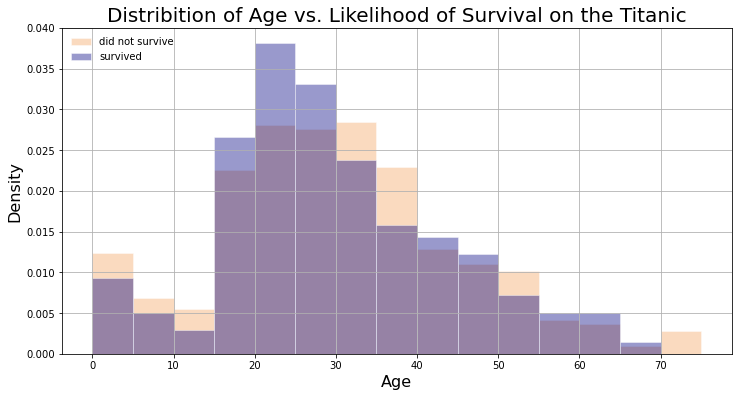

In [115]:
dfSurvived = dfTitanic.loc[dfTitanic["Survived"] == 1]
dfKickedCan = dfTitanic.loc[dfTitanic["Survived"] == 0]

my_bins = range(0,80,5)
fig, ax = plt.subplots(figsize = (12, 6))
dfKickedCan["Age"].hist(ax = ax, bins = my_bins, facecolor = "sandybrown", edgecolor = "white", alpha = 0.4, label = "did not survive", stacked = True, density = True)
dfSurvived["Age"].hist(ax = ax, bins = my_bins, facecolor = "navy", edgecolor = "white", alpha = 0.4, label = "survived", stacked = True, density = True)


ax.set_title("Distribition of Age vs. Likelihood of Survival on the Titanic", fontsize = 20)
ax.set_xlabel("Age", fontsize = 16)
ax.set_ylabel("Density", fontsize = 16)
ax.legend(loc = 'upper left', frameon = False)

For nearly all age ranges, a passenger was more likely to not have survived than to have survived. People aged less than 15 had about a 66% chance of not surviving. People between the ages of 15 and 30 had the highest likelihood of survival apart from those who were the oldest on the ship at a little under 45%. Those aged between 30 and 40 had about the same chance of survival as those below 15 years of age. From age 40 and up, we see a trend of increasing likelihood of survival, with those over 70 being an outlier. 

In short, those aged between 40 and 70, and those aged between 15 and 30 had the highest chance of surviving. This may show that both the theory that older folks would have been favored and that younger, more able people could have fought to get a spot on a lifeboat could hold true to some degree. The low likelihood of children surviving could be explained by their frailty, as we might expect their survival rate to somewhat mirror that of the elderly. 

**Part F:** In Part E, we plotted two *density* histograms, showing the distributions of ages of passengers that survived or did not survive the Titanic disaster. Why would it be misleading for us to have plotted these as *frequency* histograms instead?

For this problem we want to know to what degree age had a bearing on survival for each age group *as compared to other age groups.* Were we to use a frequency histogram, we could see how many people in each age group either died or survived, but one would have to do further interpretation themself in order to discern how the count for a particular age group relates to other age groups. A density histogram does that for us. 

**Part G**: Do the data suggest class warfare, male chivalry, age bias, or some combination of these characteristics in the final hours aboard the Titanic?  Justify your conclusions based on the computations done above, or do any other analysis that you like, but be sure to clearly justify your conclusions.

The data analysis here shows that there is a clear bias towards first-class women, with 96% of people in that demographic surviving. In fact, women, regardless of class, and first-class passengers, regardless of sex, survived at a higher rate than men or lower-class passengers, likewise. The histogram shows strong favoritism towards people aged between 15 and 30, and slight favoritism towards those between 40 and 70. In conclusion, all of the theories mentioned hold water to some degree, but the clearest divides exist when observing class and sex.

**P.S.** It is not a component of your graded assignment, but the 1997 James Cameron film _Titanic_ captured some of these very notions in some riveting cinema. Whether or not you found evidence for these cases in the data, you might find it interesting to watch the movie (or just the segments of the sinking) to see one interpretation of these ideas. You can perhaps see how we might be persuaded to reinterpret the evidence of data by a heart-wrenching performance from a handsome young Leonardo DiCaprio!

<a id='Appendix'></a>

## Appendix 

*Goal*: Prove that 
$$
\bar{x}_n = \bar{x}_{n-1} + \frac{x_n - \bar{x}_{n-1}}{n}
$$

Note that you can get an expression for $\bar{x}_{n-1}$ by simply replacing $n$ in Equation 1 above with $n-1$.

We'll start with $\bar{x}_n$ and massage it until we get the righthand side of the formula

\begin{eqnarray}
\nonumber \bar{x}_n &=& \frac{1}{n} \sum_{k=1}^n x_k \\
&=& \frac{1}{n} \sum_{k=1}^{n-1} x_k + \frac{1}{n}x_n \\
&=& \frac{n-1}{n-1}\frac{1}{n} \sum_{k=1}^{n-1} x_k + \frac{1}{n}x_n \\
&=& \frac{n-1}{n} \left(\frac{1}{n-1} \sum_{k=1}^{n-1} x_k\right) + \frac{1}{n}x_n \\
&=& \frac{n-1}{n} \bar{x}_{n-1} + \frac{1}{n}x_n \\
&=& \frac{n}{n}\bar{x}_{n-1} - \frac{1}{n}\bar{x}_{n-1} + \frac{1}{n}x_n \\
&=&  \bar{x}_{n-1} + \frac{x_n - \bar{x}_{n-1}}{n} \quad \checkmark
\end{eqnarray}

